# Moment dynamics with cell division (MaxEnt approach)

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import pickle
import cloudpickle
import itertools
import glob

# Our numerical workhorses
import math
import numpy as np
import scipy as sp
import pandas as pd
import numba

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Distribution moment dynamics with cell division 

As first discussed by [Jones et al.](http://science.sciencemag.org/content/346/6216/1533) and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the genome replication origin.

For our experimental setup our cells spend 40% of the cell cycle with 2 copies of the reporter gene and 60% with one copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell doubling time $t_d = 90$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

## Cell division and the issue with higher moments.

After the cells reach a time $t_d$ the content of the cells is assumed to binomially partition between the two daughter cells. The only moment that can be trivally computed after the cell division is the mean mRNA $\ee{m}$ and mean protein $\ee{p}$. For example, if the mean protein before the n-th cell division was $\ee{p(t_d)}_{n}$, the mean protein right after the cell division would be given by
$$
\ee{p(0)}_{n + 1} = {\ee{p(t_d)}_{n} \over 2},
$$
since on average cells will start with half of their content. For higher moments such as $\ee{m^2}$ or $\ee{mp^2}$ it is not as trivial to compute what these moments should be after cell division.

### Using MaxEnt + Binomal distribution

The method we will use in this notebook will consist of the following procedure. Before the cell divides we have a value for the moments of the distribution of the form $\ee{m^x p^y}$ for $x, y \in \mathbb{N}$. From these moments we can use the MaxEnt principle (explained elsewhere) to fit a joint distribution $P_{t_d}(m, p)$ 
$$
P_{t_d}(m, p) = {\exp\left(\sum_{(x, y)} \lambda^{(x, y)} m^x p^y \right) \over \mathcal{Z}},
$$
where the subindex $t_d$ indicates that this is fit just at the moment of cell division. Once we approximate the distribution before the cell division we can compute the distribution after cell division $P_{t_o}(m, p)$ as
$$
P_{t_o}(m, p) = \sum_{m'} \sum_{p'} P(m, p \mid m', p') P_{t_d}(m', p'),
$$
where the conditional distribution $P(m, p \mid m', p')$ is given by the product of two binomial distributions
$$
P(m, p \mid m', p') = {m' \choose m} \left( {1 \over 2} \right)^{m'}
{p' \choose p} \left( {1 \over 2} \right)^{p'}.
$$

In [3]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 0 # sec^-1

# Define protein production to have ≈ 500 protein/mRNA
rp = 0.057  # sec^-1

## Defining moment dynamics 

We have already on the `moment_dynamics_system.ipynb` notebook established the dynamics up to the 6th protein moment. In general we established that the moment dynamics are of the form

$$
\dt{\bb{\mu^{(x, y)}}} = \bb{A \mu^{(x, y)}},
\tag{1}
$$
where $\bb{\mu^{(x, y)}}$ is the array containing all of our moments, and the matrix $\bb{A}$ contains the linear coefficients of our linear system.

Let us begin by defining a function `dmomdt` that takes as input an array of moments `m`, a time array `t` and a matrix `A` and returns the right-hand side of the equation for the moment dynamics. This function will be fed to the `scipy.integrate.odeint` function.

In [4]:
def dmomdt(mom, t, A):
    '''
    Function that computes the right-hand side of the moment
    dynamics equation
    dµ/dt = Aµ
    This funciton is fed to the scipy.integrate.odeint function
    Parameters
    ----------
    mom : array-like
        Array containing all of the moments included in the matrix
        dynamics A.
    t : array-like
        time array
    A : 2D-array.
        Matrix containing the linear coefficients of the moment
        dynamics equation
    Returns
    -------
    Right hand-side of the moment dynamics
    '''
    return np.dot(A, mom)

### Running dynamics until steady state.

If our model were not to consider explicit cell divisions, and we were to set the protein degradation rate to be $\gp > 0$ all moments of the distribution would reach a steady state-value. Taking advantage of that fact we will use these steady-state values as the initial condition for our numerical integration. This is because starting at a non-zero value that is close to the value that the moments would experience over cell cycles makes more sense than starting all moments for example at zero.

Let's define the matrix $\bb{A}$ to compute the initial conditions then. Again, since we will not explicitly include cell divisions we need to set a non-zero degradation rate such that these steady state value can be reached. Therefore to compute these initial conditions we will use a production rate `rp_init` and a protein degradation rate `gp_init` such that the mean protein copy number is 500 times the mean mRNA copy number. that means that ${r_p \over \gp} = 500$.

In [5]:
# Single promoter
gp_init = 1 / (60 * 60)
rp_init = 500 * gp_init

# Read protein ununregulated matrix 
with open('./two_state_protein_third_mom.pkl', 'rb') as file:
    # Load sympy object containing the matrix A that define the
    # moment dynamics
    A_mat_unreg_lam = cloudpickle.load(file)
    # Load the list of moments included in the matrix
    expo = cloudpickle.load(file)
    
# Substitute value of parameters on matrix
##  Initial conditions
A_mat_unreg_s_init = A_mat_unreg_lam(kp_on, kp_off, rm, gm, rp_init, gp_init)

Now we will run the dynamics with the "artificial" $r_p$ and $\gp$ for a long time (equivalent to several cell cycles) such that all moments reach steady state.
We will initialize all moments except the zeroth moment to be zero. The zeroth moment represents the probability of being on any of the promoter states, and the sum has to always add up to 1. So given this subtle but important detail let's run the dynamics until reaching steady state.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 4000 * 60, 2000)

# Define initial conditions
mom_init = np.zeros(len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Numerically integrate equations
mp_sol = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_unreg_s_init,))

mp_init = mp_sol[-1, :]

print('<m> = {:.1f}'.format(mp_init[2:4].sum()))
print('<p> = {:.1f}'.format(mp_init[8:10].sum()))
print('<p>/<m> = {:.1f}'.format(mp_init[8:10].sum() / mp_init[2:4].sum()))

<m> = 12.0
<p> = 5982.3
<p>/<m> = 500.0


Excellent so we can see from this that as expected the mean protein copy number per mRNA is 500. That indicates that the dynamics ran long enough to reach the expected steady state.

### Fitting a MaxEnt distribution to the last point.

Before moving to the real case let's test our method with this steady state values. First we will take the moments and fit a MaxEnt distribution to them.

In [7]:
# Define the list of moments
moments = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1),
           (1, 1), (0, 2), (2, 1), (1, 2), (0, 3)]

# Compute the moments by reshaping the array and
# adding the contributions of each state
mom_init = np.reshape(mp_init, [-1, 2]).sum(axis=1)

# Define sample space
mRNA_space = np.arange(0, 50, dtype=np.int)
protein_space = np.arange(0, 2E4, dtype=np.int)

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [ccutils.maxent.feature_fn(x, mom) for x in samplespace]

Having define all we need to perform the MaxEnt computation let's fit the Lagrange multipliers. For this we will use our implementation of the Bretthorst algorithm.

In [8]:
# Perform MaxEnt computation
# We use the Powell method because despite being slower it is more
# robust than the other implementations.
Lagrange = ccutils.maxent.MaxEnt_bretthorst(mom_init, features, 
                                            algorithm='BFGS', 
                                            tol=1E-3, paramtol=1E-3,
                                            maxiter=5000)

Wow, that took a long time. Let's reconstruct the distribution.

In [9]:
# Generate the joint distribution given the
Pmp = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, protein_space,
                                          Lagrange, moments)

Let's look at the joint distribution.

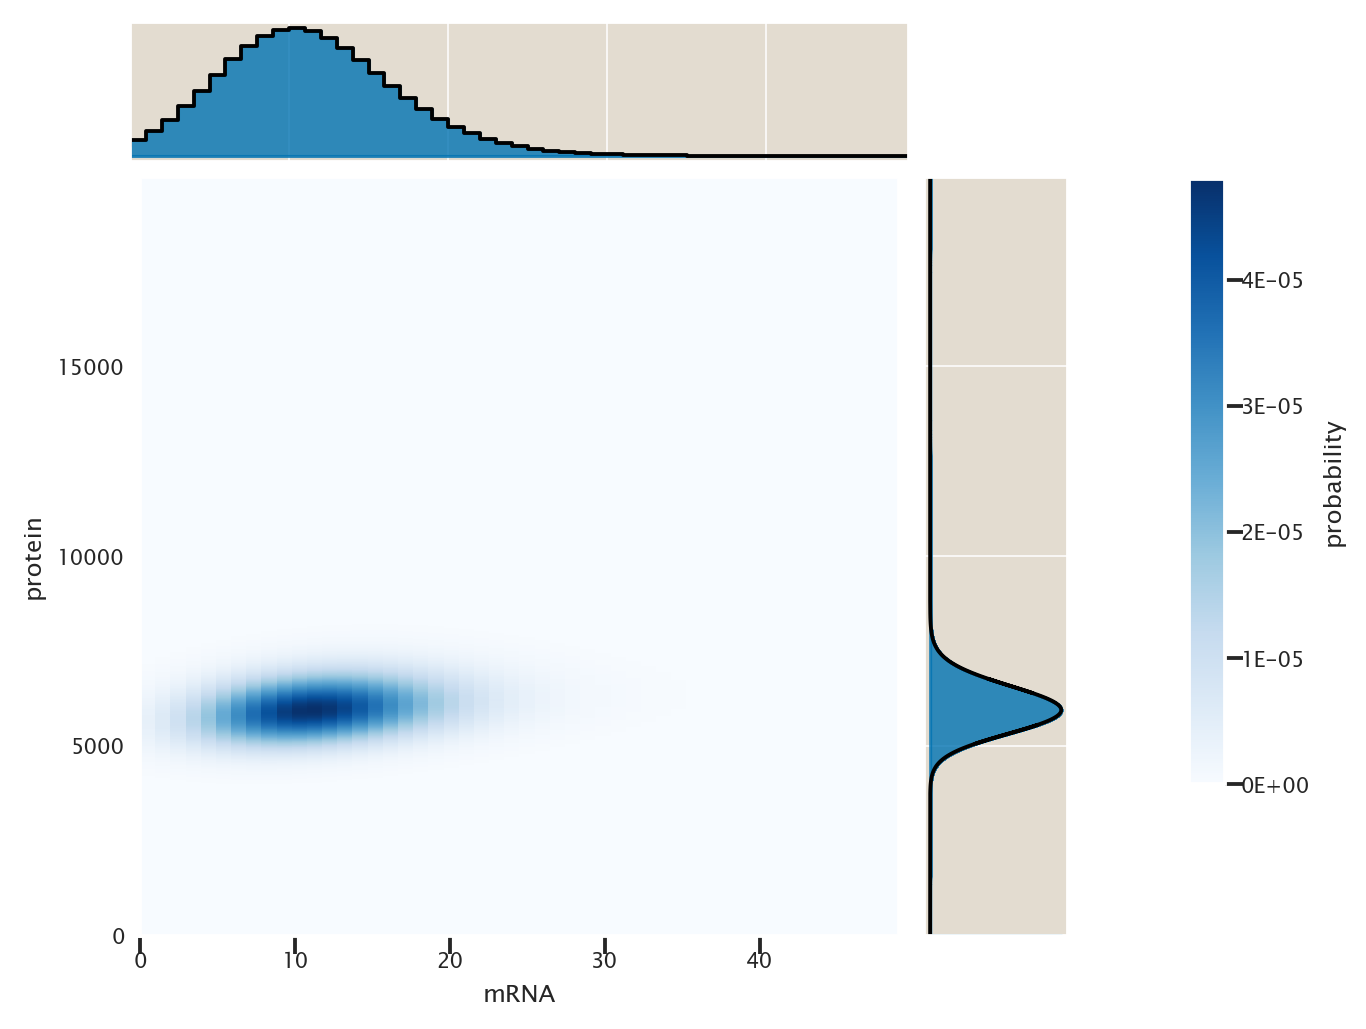

In [10]:
ccutils.viz.joint_marginal_plot(mRNA_space, protein_space, Pmp,
                                xlabel='mRNA', ylabel='protein')

Okay, that is definitely not the right range. There was a lot of empty space for the protein and the mRNA. Let's zoom in

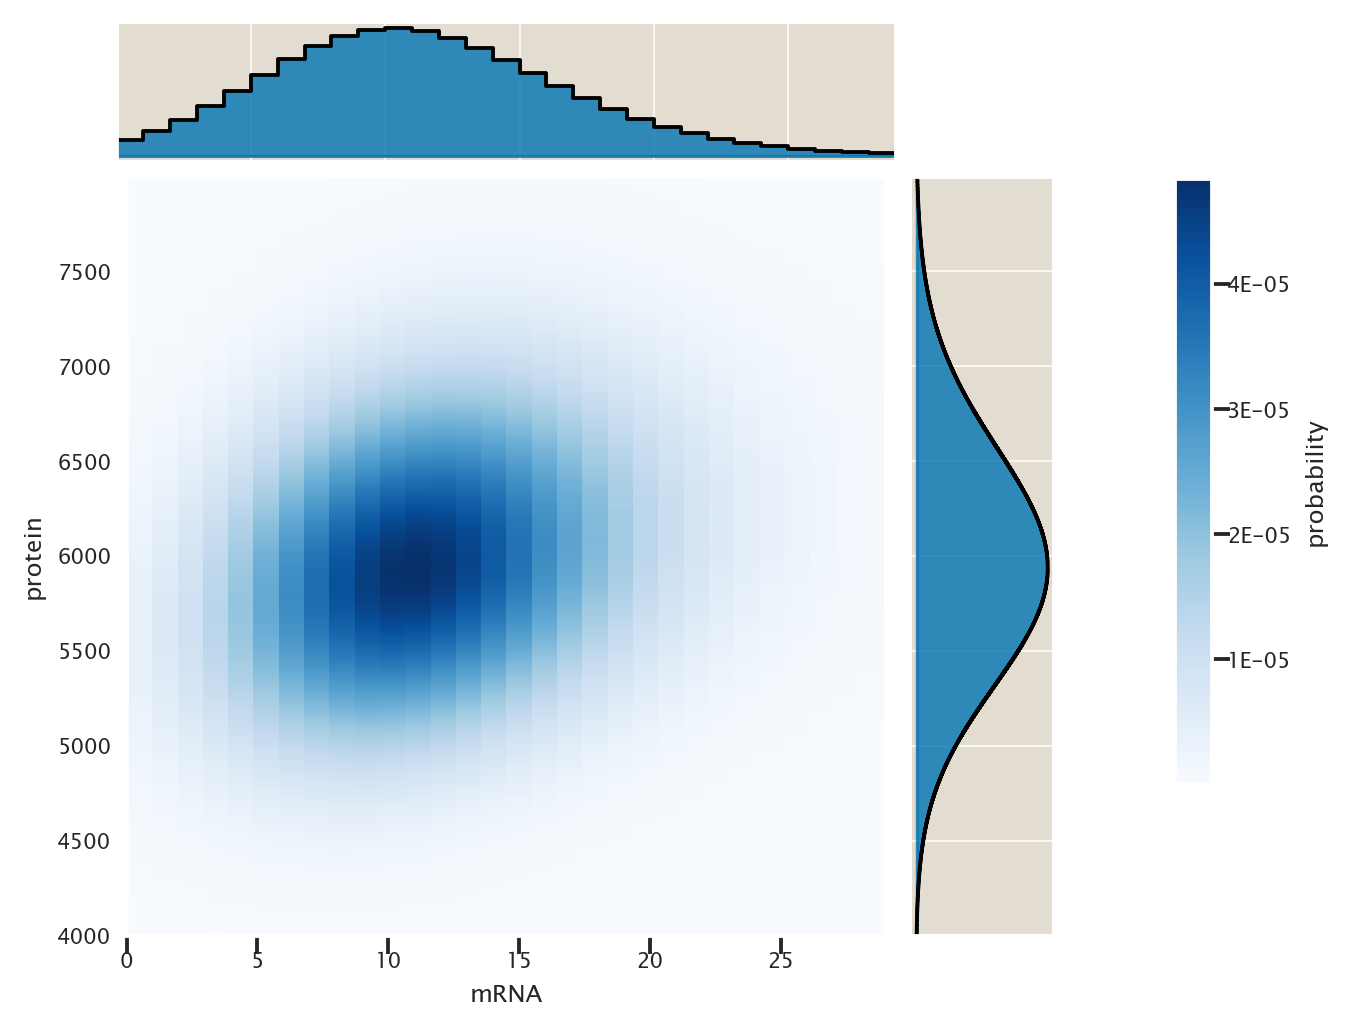

In [11]:
mRNA = mRNA_space[0:30]
protein = protein_space[4000:8000]
# Generate the joint distribution given the
Pmp = ccutils.maxent.maxEnt_from_lagrange(mRNA, protein,
                                          Lagrange, moments)
ccutils.viz.joint_marginal_plot(mRNA, protein, Pmp,
                                xlabel='mRNA', ylabel='protein')

This looks pretty good.

### Computing the binomial distribution.

For the conditional distribution we have to compute a binomial distribution.
Let's look at how long it takes to do the computation with scipy stats for small numbers at the scale of the mRNA level.

In [12]:
print('Scipy binomial for mRNA distribution:')
%timeit sp.stats.binom.pmf(mRNA_space, mRNA_space.max(), 0.5)

Scipy binomial for mRNA distribution:
106 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now let's take a look at the time it takes for something much larger like the protien distribution, where there will be huge factorials computed.

In [13]:
print('Scipy binomial for protein distribution:')
%timeit sp.stats.binom.pmf(protein_space, protein_space.max(), 0.5)

Scipy binomial for protein distribution:
4.53 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That is significantly slower.

The binomial distribution can be approximated by a Normal distribution with mean $\mu = Np$ and variance $\sigma^2 = Np(1 - p)$. So to compute the probability of a binomial random variable we can compute
$$
P_{binom}(n) \approx P_{norm}(x \leq n) -
                               P_{norm}(x \leq n - 1),
$$
where $P_{binom}(n)$ indicates a binomial distribution and $P_{norm}$(x \leq n) indicates the cumulative distribution function of the normal distribution.
Let's test this approximation.




In [14]:
# Compute the distribution using the scipy binomial function
scipy_binom = sp.stats.binom.pmf(protein_space, protein_space.max(), 0.5)

# Define parameters for normal
mu = protein_space.max() * 0.5
sigma = np.sqrt(protein_space.max() * 0.5**2)

# Compute cumulative distribution function
scipy_norm = sp.stats.norm.cdf(protein_space, mu, sigma)
scipy_norm_binom = np.diff(scipy_norm)

Now that we computed it, let's compare them both.

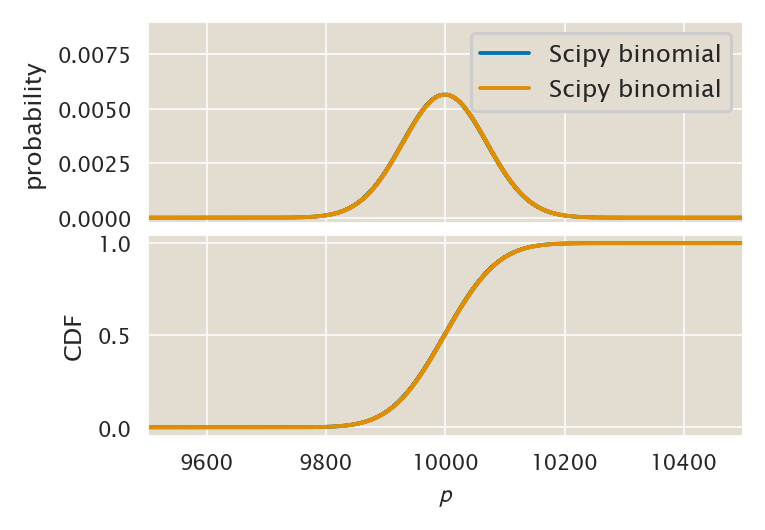

In [15]:
# Initialize figure
fig, ax = plt.subplots(2, 1, sharex=True)

# Plot binomial distribution
ax[0].step(protein_space, scipy_binom, label='Scipy binomial')
ax[1].step(protein_space, np.cumsum(scipy_binom), label='Scipy binomial')

# Plot Gaussian approximation
ax[0].step(protein_space[1::1], scipy_norm_binom,
           label='Scipy binomial')
ax[1].step(protein_space[1::1], np.cumsum(scipy_norm_binom),
           label='Scipy normal approx')

# Label axis
ax[0].set_ylabel('probability')
ax[1].set_ylabel('CDF')
ax[1].set_xlabel(r'$p$')

# Add legend
ax[0].legend()

# Change axis limit
ax[1].set_xlim([9500, 10500])
ax[0].set_ylim(top=0.009)

# Set spacing between plots
plt.subplots_adjust(hspace=0.05)

As we can see this overlap is basically perfect. So the Gaussian approximation is great for this copy number. Let's now take a look at the time each computation takes.

In [16]:
print('Scipy binomial distribution:')
%timeit sp.stats.binom.pmf(protein_space, protein_space.max(), 0.5)

# Define parameters for normal
mu = protein_space.max() * 0.5
sigma = np.sqrt(protein_space.max() * 0.5**2)

print('Scipy Gaussian approximation:')
%timeit sp.stats.norm.cdf(protein_space, mu, sigma)
print('Numpy cumulative sum:')
%timeit np.diff(scipy_norm)

Scipy binomial distribution:
4.54 ms ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Scipy Gaussian approximation:
803 µs ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Numpy cumulative sum:
20.1 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


There is a significant improvement of almost a factor of 5 with our Gaussian approximation! So we'll take it. Let's define a function that directly computes the binomial approximation.

In [17]:
def binom_approx(x, n, p=0.5):
    '''
    Computes an approximation of the binomial distribution using a
    Gaussian distribution. The approximation works for large n.
    Parameters
    ----------
    x : array-like.
        Values where to evaluate the distribuion. 
        NOTE: The spacing between entries should be 1
    n : int.
        Number of coin flips in binomial distribution.
    p : float. Must be in [0, 1]. Default = 0.5
        Probability of heads in binomial
    '''
    # Define parameters for normal
    mu = n * p
    sigma = np.sqrt(n * p * (1 - p))

    # Compute Gaussian CDF
    gauss_cdf = sp.stats.norm.cdf(x, mu, sigma)
    # Compute normal PMF approximation
    pmf = np.diff(gauss_cdf)
    
    # Append zero for the first entry and return
    return np.insert(0, 1, pmf)

Let's make sure that our function is equally efficient.

In [18]:
%timeit binom_approx(protein_space, protein_space.max())

897 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pre-computed binomial distributions

The computation of these binomial distributions is extremely slow, to the point that it is the bottleneck for our pipeline. So instead we are going to try to pre-compute these binomial distributions and have them stored in memory to simply index them. Let's begin with the mRNA binomial distribution.

In [26]:
# Define mRNA space:
mRNA_space = np.arange(51)

# Initialize matrix to save distribution
mRNA_binom = np.zeros([len(mRNA_space), len(mRNA_space)])

# Loop through mRNA values
for m in mRNA_space:
    # Compute mRNA distribution
    mRNA_binom[m, 0:m+1] = sp.stats.binom.pmf(mRNA_space[0:m+1],
                                              m, 0.5)

np.sav

Having this ready let's now define a function that computes the resulting distribution after cell division.

In [154]:
def Pmp_div(mRNA_space, protein_space, Pmp,
            protein_div_space,
            p_div=0.5):
    '''
    Function that takes the joint distribution P(m, p) before cell division
    and computes the probability after a binomial partitioning takes place
    Parameters
    ----------
    mRNA_space, protein_space : array-like
        Sample space for both the mRNA and the protein.
    Pmp : array-like
        Joint distribution before cell division.
        NOTE: The dimensions should be len(mRNA_space) x len(protein_space)
    p_div : float. [0,1]. Default = 0.5
        Probability of binomial partitioning.
    Returns
    -------
    Pmp_div : array-like
        Probability distribution after cell division.
    '''
    # Initialize 3D array to save all conditional distributions 
    # P(m, p | m', p')
    Pmp_mp = np.empty([len(mRNA_space), len(protein_div_space),
                       len(mRNA_space) * len(protein_space)])
    
    # Initialize counter
    idx = 0
    # Loop through each pair of mRNA and protein
    for j, p in enumerate(protein_space):
        # Compute protein distribution
        Pp = binom_approx(protein_div_space, p, p_div)
        for i, m in enumerate(mRNA_space):
            # Compute mRNA binomial distribution
            Pm = sp.stats.binom.pmf(mRNA_space, m, p_div)
            
            # Generate meshgrid to compute product
            Pmm, Ppp = np.meshgrid(Pm, Pp)
            # Compute and store product
            Pmp_mp[:, :, idx] = (Pmm * Ppp * Pmp[i, j]).T
            # Update counter
            idx +=1
            
    
    # Return maginalized distribution
    return Pmp_mp.sum(axis=2)

Let's test the function.

In [ ]:
# Define mRNA space
mRNA_space = np.arange(40)

# Define protein_space to be mean +- 2.5 STD
prot_mu = mom_init[4]
prot_sigma = np.sqrt(mom_init[6] - prot_mu**2)
protein_space = np.arange(int(prot_mu - 2.5 * prot_sigma),
                          int(prot_mu + 2.5 * prot_sigma))
protein_div_space = np.arange(int(prot_mu / 2 - 2.5 * prot_sigma),
                          int(prot_mu / 2 + 2.5 * prot_sigma))

Pmp = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, protein_space,
                                          Lagrange, moments).T

# Pmp_new = Pmp_div(mRNA_space, protein_space, Pmp, protein_div_space)